In [1]:
import os
from time import time
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.datasets import MNIST
import idx2numpy
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class FFNN(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        fc1 = nn.Linear(in_shape, 64)
        a1  = nn.ReLU()
        fc2 = nn.Linear(64, 32)
        a2  = nn.ReLU()
        fc3 = nn.Linear(32, out_shape)
        
        # not applying log_softmax here, as it is applied later in 
        # the torch CCE loss
        
        self.nn = nn.Sequential(fc1, a1, fc2, a2, fc3)

    def forward(self, x):
        x = self.nn(x)
        return x

In [3]:
# define dataset splits 
transforms = T.Compose([T.ToTensor(), T.Normalize((0.5,),(0.5)), T.Lambda(lambda x: torch.flatten(x))])

dataset_train = MNIST(root='/data/', transform=transforms, train=True)
dataset_test  = MNIST(root='/data/', transform=transforms, train=False)

# create dataloaders
train_args = {'dataset':dataset_train, 'batch_size':512, 'shuffle':True, 'num_workers':8, 'pin_memory':True}
dataloader_train = torch.utils.data.DataLoader(**train_args)
test_args  = {'dataset':dataset_test, 'batch_size':len(dataset_test), 'shuffle':False, 'num_workers':8}
dataloader_test  = torch.utils.data.DataLoader(**test_args) 

/home/chris/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
spacer = '#' * 40 # for printing purposes

# setup model
num_classes = 10 # amount of classes in mnist
flattened_shape = torch.prod(torch.tensor(dataset_train[0][0].shape))
model = FFNN(flattened_shape, num_classes)
print(model)

# train parameters
n_epochs = 10
learning_rate = 1e-3

optimiser = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
f_loss = nn.CrossEntropyLoss()

# configure hardware acceleration
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)
print(f'using torch on {device}')

# logging data
log = pd.DataFrame(columns=['loss', 'train_accuracy', 'test_accuracy'])

# time keeping
start_time = time()
print(f'{spacer}\nstarting training at {datetime.fromtimestamp(int(start_time))}\n{spacer}')

### main training loop
for n in range(n_epochs):
    total_loss = 0
    # optimisation
    model.train()
    for idx, (X, y) in enumerate(dataloader_train):
        X, y = X.to(device), y.to(device)
        optimiser.zero_grad()
        y_pred = model(X) # forward
        # y = F.one_hot(y, num_classes) # create one_hot tensor for predictions 
        # creating one_hot tensor is unnecessary as the torch cross entropy function
        # applies softmax and takes argmax from output.
        loss = f_loss(y_pred, y)
        loss.backward()
        total_loss += loss.detach().cpu().item() / len(y) # normalise for batch size
        optimiser.step()
        
    # train set metrics
    predictions, targets = [], []
    model.eval()
    for idx, (X, y) in enumerate(dataloader_train):
        predictions.append(model(X).detach())
        targets.append(y)
        
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    predictions = torch.argmax(F.log_softmax(predictions, dim=1),dim=1)
    corrects = (predictions == targets).sum().item()
    wrongs = len(targets) - corrects
    train_accuracy = corrects / len(targets)
    
    predictions, targets = [], []
    model.eval()
    for idx, (X, y) in enumerate(dataloader_test):
        predictions.append(model(X).detach())
        targets.append(y)
        
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)
    predictions = torch.argmax(F.log_softmax(predictions, dim=1),dim=1)
    corrects = (predictions == targets).sum().item()
    wrongs = len(targets) - corrects
    test_accuracy = corrects / len(targets)
        
    print(f'epoch:{n}, total_loss: {total_loss:.4f}')
    log = log.append({'loss':total_loss, 'train_accuracy':train_accuracy, 'test_accuracy':test_accuracy}, ignore_index=True)

# time keeping
end_time = time()
duration = end_time - start_time
print(f'{spacer}\ntraining finished at {datetime.fromtimestamp(int(end_time))}\n{spacer}')
print(f'\nscript duration {timedelta(seconds=duration)}')

FFNN(
  (nn): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)
using torch on cpu
########################################
starting training at 2021-07-04 18:10:43
########################################
epoch:0, total_loss: 0.5420
epoch:1, total_loss: 0.4894
epoch:2, total_loss: 0.3788
epoch:3, total_loss: 0.2628
epoch:4, total_loss: 0.1917
epoch:5, total_loss: 0.1571
epoch:6, total_loss: 0.1369
epoch:7, total_loss: 0.1224
epoch:8, total_loss: 0.1138
epoch:9, total_loss: 0.1073
########################################
training finished at 2021-07-04 18:11:42
########################################

script duration 0:00:59.427100


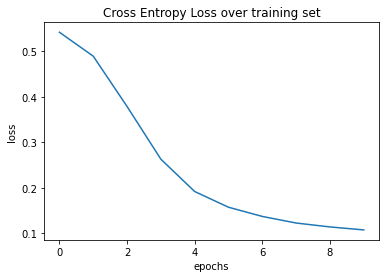

In [5]:
log.plot(y='loss', title='Cross Entropy Loss over training set', xlabel='epochs', ylabel='loss', legend=False)
plt.show()

[]

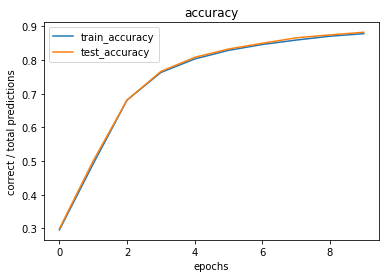

In [6]:
log.plot(y=['train_accuracy', 'test_accuracy'], 
         title='accuracy',
         xlabel='epochs', ylabel='correct / total predictions')
plt.plot()